In [7]:
# for running in collab, sagemaker etc.
import sys
sys.path.insert(0, "/home/studio-lab-user/Generative_Models_for_CERN_Fast_Simulations/utils")

In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.11.0


### Load and process data

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
import sklearn
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [4]:
data = pd.read_pickle('../data/data_proton_photonsum_70_2312.pkl')
print('Loaded: ',  data.shape, "max:", data.max())

data_cond = pd.read_pickle('../data/data_cond_photonsum_70_2312_0_3360.pkl')
print('Loaded cond: ',  data_cond.shape, "max:",data_cond.values.max(), "min:",data_cond.values.min())

Loaded:  (40853, 56, 30) max: 765.0
Loaded cond:  (40853, 12) max: 7000.0 min: -7000.0


In [5]:
photon_sum_proton_min, photon_sum_proton_max = data_cond.proton_photon_sum.min(), data_cond.proton_photon_sum.max()
photon_sum_neutron_min, photon_sum_neutron_max = data_cond.neutron_photon_sum.min(), data_cond.neutron_photon_sum.max()

In [6]:
data_cond.drop(columns=['proton_photon_sum', 'neutron_photon_sum'], inplace=True)
data_cond.columns, len(data_cond.columns)

(Index(['Pdg', 'Energy', 'Vx', 'Vy', 'Vz', 'Px', 'Py', 'Pz', 'mass', 'charge'], dtype='object'),
 10)

In [7]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "gan"

EXPERIMENT_DIR_NAME = f"{NAME}_{DATE_STR}"

print("Experiment DIR: ", EXPERIMENT_DIR_NAME)

Experiment DIR:  gan_14_03_2023_11_23


In [8]:
def create_dir(path):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

In [9]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)

    filepath = f"../models/{EXPERIMENT_DIR_NAME}/"
    create_dir(filepath)
    with open(filepath+out_fnm, mode="w") as f:
        f.write(res)

In [10]:
data = np.log(data+1)
data = np.float32(data)
print("data max", data.max(), "min", data.min())

scaler = StandardScaler()
data_cond = np.float32(data_cond)
data_cond = scaler.fit_transform(data_cond)
print("cond max", data_cond.max(), "min", data_cond.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

data max 6.641182 min 0.0
cond max 8.353683 min -7.9837365


In [11]:
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(32682, 56, 30) (8171, 56, 30) (32682, 10) (8171, 10)


In [12]:
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
fake_cond =  tf.data.Dataset.from_tensor_slices(y_train).shuffle(12800).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond, fake_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_fake_cond =  tf.data.Dataset.from_tensor_slices(y_test).shuffle(12800).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond,val_fake_cond)).shuffle(12800)

### Define Model

In [13]:
from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from tensorflow import keras

In [14]:
latent_dim = 10
cond_dim = 10
poz_dim = 6

############################ generator ############################

x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

layer_1 = Dense(128*2)(inputs)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

layer_2 = Dense(128*8*4)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

reshaped = Reshape((8,4,128))(layer_2_a)
reshaped_s = UpSampling2D(size=(2,2))(reshaped)

conv1 = Conv2D(128, kernel_size=3, padding='same')(reshaped_s)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
conv1_a_s = UpSampling2D(size=(4,4))(conv1_a)

conv2 = Conv2D(64, kernel_size=(7, 1))(conv1_a_s)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

outputs = Conv2D(1, kernel_size=3, activation='relu')(conv2_a)

generator = Model([x, cond], outputs, name='generator')
generator.summary()

############################ discriminator ############################

input_img = Input(shape=[56,30,1],name='input_img')
conv1 = Conv2D(32, kernel_size=3)(input_img)
conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
conv2 = Conv2D(16, kernel_size=3)(pool1)
conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
pool2 = MaxPooling2D(pool_size=(2, 1))(conv2_a)
flat = Flatten()(pool2)
cond = Input(shape=(cond_dim,))
inputs2 = Concatenate(axis=1)([flat, cond])
layer_1 = Dense(128)(inputs2)
layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
layer_2 = Dense(64)(layer_1_a)
layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
outputs = Dense(1, activation='sigmoid')(layer_2_a)

discriminator = Model([input_img, cond], outputs, name='discriminator')
discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          5376        ['concatenate[0][0]']    

In [15]:
# latent_dim = 10
# cond_dim = 10
# poz_dim = 6

# ############################ generator ############################

# x = Input(shape=(latent_dim,))
# cond = Input(shape=(cond_dim,))
# inputs = Concatenate(axis=1)([x, cond])

# layer_1 = Dense(128*2)(inputs)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)

# layer_2 = Dense(128*28*15)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)

# reshaped = Reshape((28, 15, 128))(layer_2_a)
# # reshaped_s = UpSampling2D()(reshaped)

# conv1 = Conv2D(128, kernel_size=1)(reshaped)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# conv1_a_s = UpSampling2D()(conv1_a)

# conv2 = Conv2D(64, kernel_size=1)(conv1_a_s)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)

# outputs = Conv2D(1, kernel_size=1,activation='relu')(conv2_a)

# generator = Model([x, cond], outputs, name='generator')
# generator.summary()

# ############################ discriminator ############################

# input_img = Input(shape=[56,30,1],name='input_img')
# conv1 = Conv2D(32, kernel_size=3)(input_img)
# conv1_bd = Dropout(0.2)(BatchNormalization()(conv1))
# conv1_a = LeakyReLU(alpha=0.1)(conv1_bd)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_a)
# conv2 = Conv2D(16, kernel_size=3)(pool1)
# conv2_bd = Dropout(0.2)(BatchNormalization()(conv2))
# conv2_a = LeakyReLU(alpha=0.1)(conv2_bd)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_a)
# flat = Flatten()(pool2)
# cond = Input(shape=(cond_dim,))

# inputs2 = Concatenate(axis=1)([flat, cond])
# layer_1 = Dense(128)(inputs2)
# layer_1_bd = Dropout(0.2)(BatchNormalization()(layer_1))
# layer_1_a = LeakyReLU(alpha=0.1)(layer_1_bd)
# layer_2 = Dense(64)(layer_1_a)
# layer_2_bd = Dropout(0.2)(BatchNormalization()(layer_2))
# layer_2_a = LeakyReLU(alpha=0.1)(layer_2_bd)
# outputs = Dense(1, activation='sigmoid')(layer_2_a)

# discriminator = Model([input_img, cond], outputs, name='discriminator')
# discriminator.summary()

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_acc_r.update_state(tf.ones_like(real_output), real_output)
    d_acc_f.update_state(tf.zeros_like(fake_output), fake_output)
    return total_loss

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

In [19]:
def generator_loss(step, fake_output):
    g_acc.update_state(tf.ones_like(fake_output), fake_output)
    return cross_entropy(tf.ones_like(fake_output), fake_output)# - div

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
EPOCHS = 100
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[20:20+num_examples_to_generate]

In [22]:
from scipy.stats import wasserstein_distance
import pandas as pd
from utils import sum_channels_parallel
from sklearn.metrics import mean_absolute_error

org=np.exp(x_test)-1
ch_org = np.array(org).reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values 
del org


def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)
    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")


In [23]:
@tf.function
def train_step(batch,step):
    images, cond, noise_cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise,noise_cond], training=True)

        real_output = discriminator([images,cond], training=True)
        fake_output = discriminator([generated_images, noise_cond], training=True)

        gen_loss = generator_loss(step, fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [24]:
filepath_mod = f"../models/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_mod)

history = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    
    # genrate first image
    generate_and_save_images(generator,
                             epochs,
                             [seed, seed_cond])

    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            gen_loss, disc_loss =train_step(batch,tf_step)
            history.append([gen_loss,disc_loss,
                100*d_acc_r.result().numpy(),
                100*d_acc_f.result().numpy(),
                100*g_acc.result().numpy(),
                ])
            tf_step.assign_add(1)
            step = step+1

            if step % 100 == 0:
                print("%d [D real acc: %.2f%%] [D fake acc: %.2f%%] [G acc: %.2f%%] "% (
                    step,
                    100*d_acc_r.result().numpy(),
                    100*d_acc_f.result().numpy(),
                    100*g_acc.result().numpy()))

        generate_and_save_images(generator,
                                 epoch,
                                 [seed, seed_cond])

        # Save the model every epoch
        generator.compile()
        discriminator.compile()
        generator.save((os.path.join(filepath_mod, "gen_"+NAME + "_"+ str(epoch) +".h5")))
        discriminator.save((os.path.join(filepath_mod, "disc_"+NAME + "_"+ str(epoch) +".h5")))
        np.savez(os.path.join(filepath_mod, "history_"+NAME+".npz"),np.array(history))

        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # generate last image
    generate_and_save_images(generator,
                             epochs + 1,
                             [seed, seed_cond]
                            )

    return history

In [25]:
filepath_img = f"../images/{EXPERIMENT_DIR_NAME}/"
create_dir(filepath_img)

def generate_and_save_images(model, epoch, test_input):
    
    SUPTITLE_TXT = f"\nModel: GAN proton data" \
               f"\nPhotonsum interval: [{photon_sum_proton_min}, {photon_sum_proton_max}]" \
               f"\nEPOCH: {epoch}"
    
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)  # returns 16 responses

    fig, axs = plt.subplots(2, 7, figsize=(15, 5))
    fig.suptitle(SUPTITLE_TXT, x=0.1, horizontalalignment='left')

    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])

    fig.tight_layout(rect=[0, 0, 1, 0.975])
    plt.savefig(os.path.join(filepath_img, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Train model

Images are saved in:  ../images/gan_14_03_2023_11_23/
Models are saved in:  ../models/gan_14_03_2023_11_23/


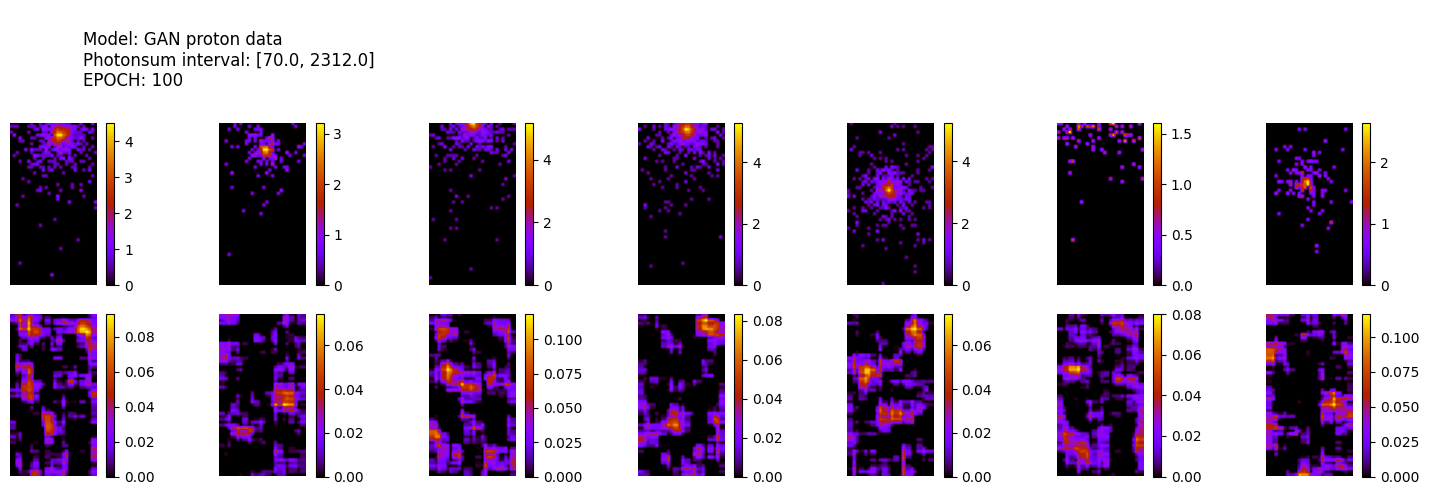

100 [D real acc: 14.94%] [D fake acc: 88.04%] [G acc: 11.96%] 
200 [D real acc: 22.45%] [D fake acc: 84.48%] [G acc: 15.52%] 


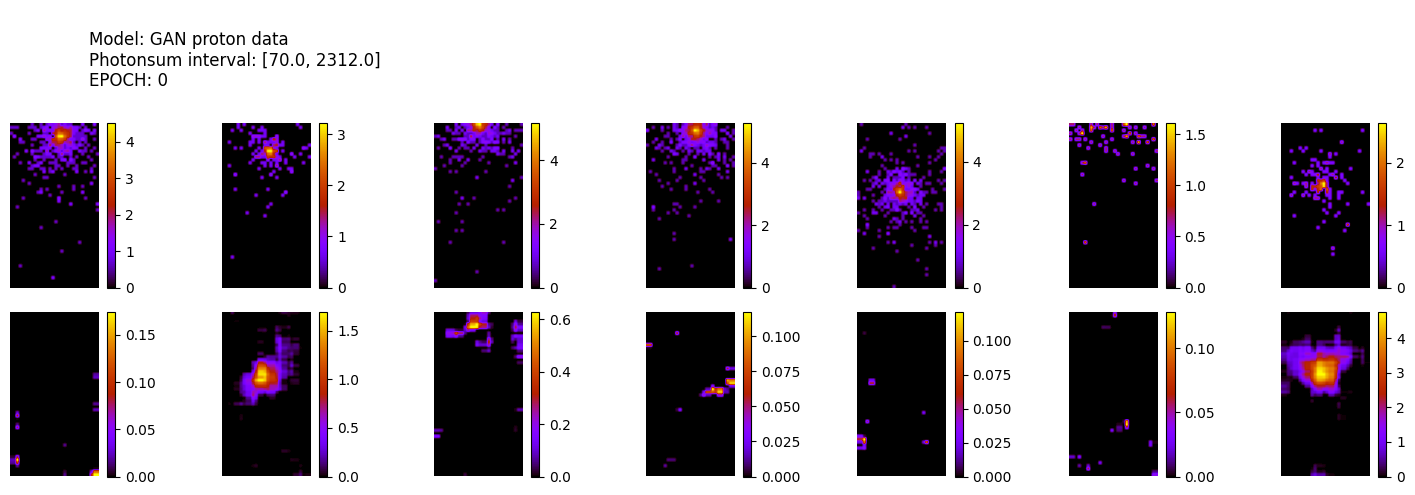

256/256 [==============================] - 1s 4ms/step
ws mean 3676.54 ch1 0.40 ch2 8737.87 ch3 0.68 ch4 479.09 ch5 9164.65 Time for epoch 1 is 34.89642953872681 sec
300 [D real acc: 30.31%] [D fake acc: 81.80%] [G acc: 18.20%] 
400 [D real acc: 38.85%] [D fake acc: 78.38%] [G acc: 21.62%] 
500 [D real acc: 45.49%] [D fake acc: 75.48%] [G acc: 24.52%] 


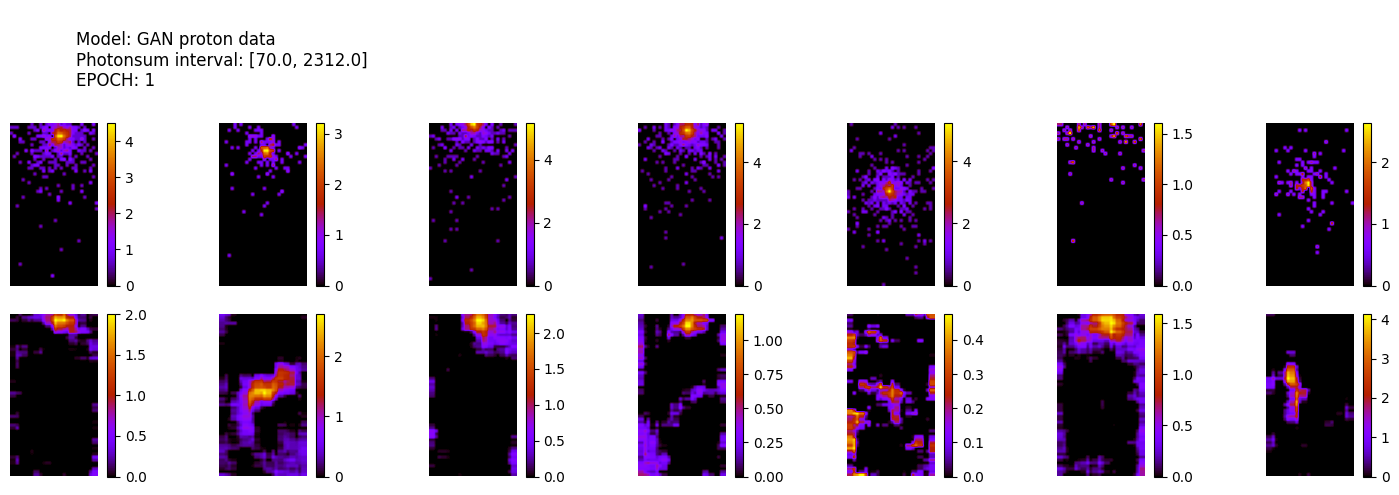

256/256 [==============================] - 1s 4ms/step
ws mean 542.99 ch1 0.18 ch2 1227.89 ch3 0.59 ch4 160.86 ch5 1325.44 Time for epoch 2 is 23.524780988693237 sec
600 [D real acc: 50.65%] [D fake acc: 72.93%] [G acc: 27.07%] 
700 [D real acc: 54.37%] [D fake acc: 71.17%] [G acc: 28.83%] 


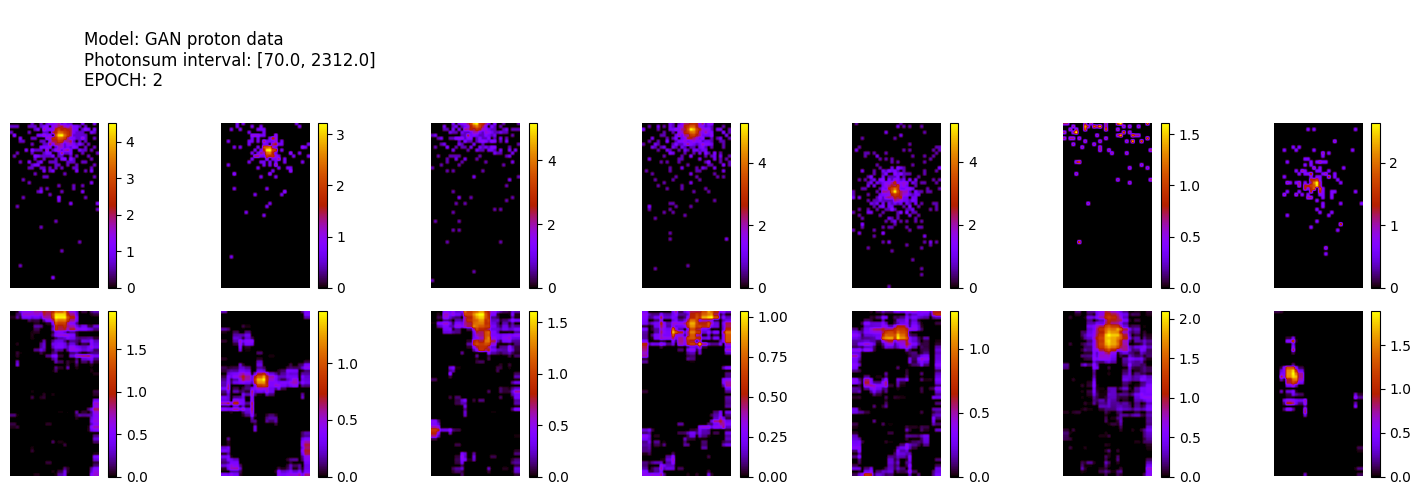

256/256 [==============================] - 1s 4ms/step
ws mean 86.72 ch1 0.09 ch2 68.26 ch3 0.57 ch4 148.86 ch5 215.83 Time for epoch 3 is 23.79732871055603 sec
800 [D real acc: 56.97%] [D fake acc: 70.20%] [G acc: 29.80%] 
900 [D real acc: 58.75%] [D fake acc: 69.79%] [G acc: 30.21%] 
1000 [D real acc: 60.15%] [D fake acc: 69.76%] [G acc: 30.24%] 


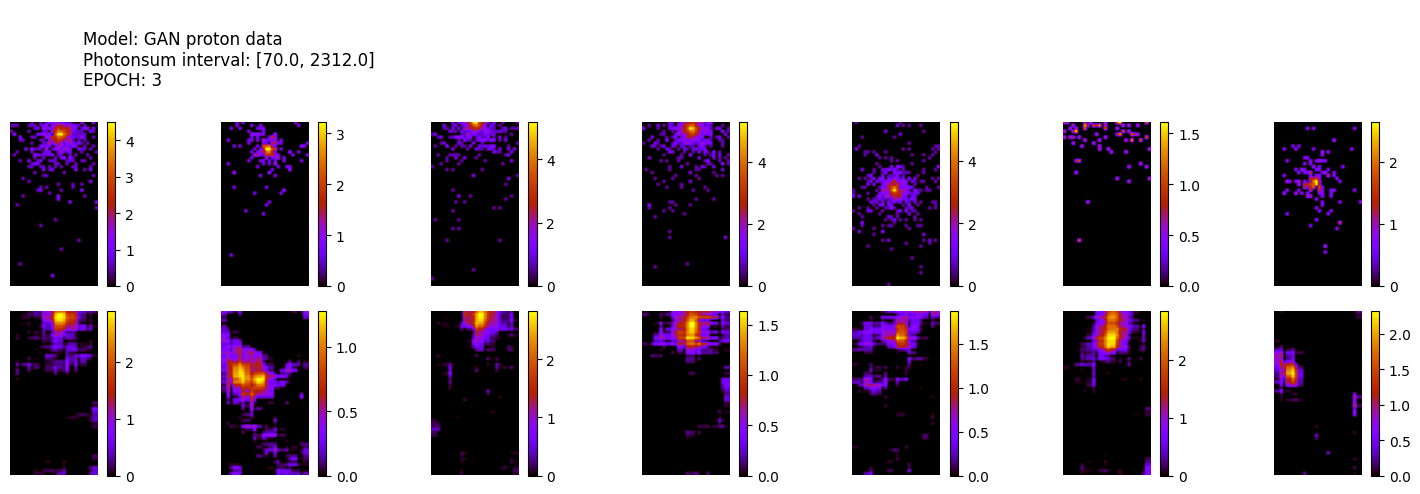

256/256 [==============================] - 1s 4ms/step
ws mean 68.27 ch1 0.10 ch2 60.60 ch3 0.40 ch4 112.83 ch5 167.42 Time for epoch 4 is 23.61331605911255 sec
1100 [D real acc: 61.35%] [D fake acc: 69.75%] [G acc: 30.25%] 
1200 [D real acc: 62.39%] [D fake acc: 69.82%] [G acc: 30.18%] 


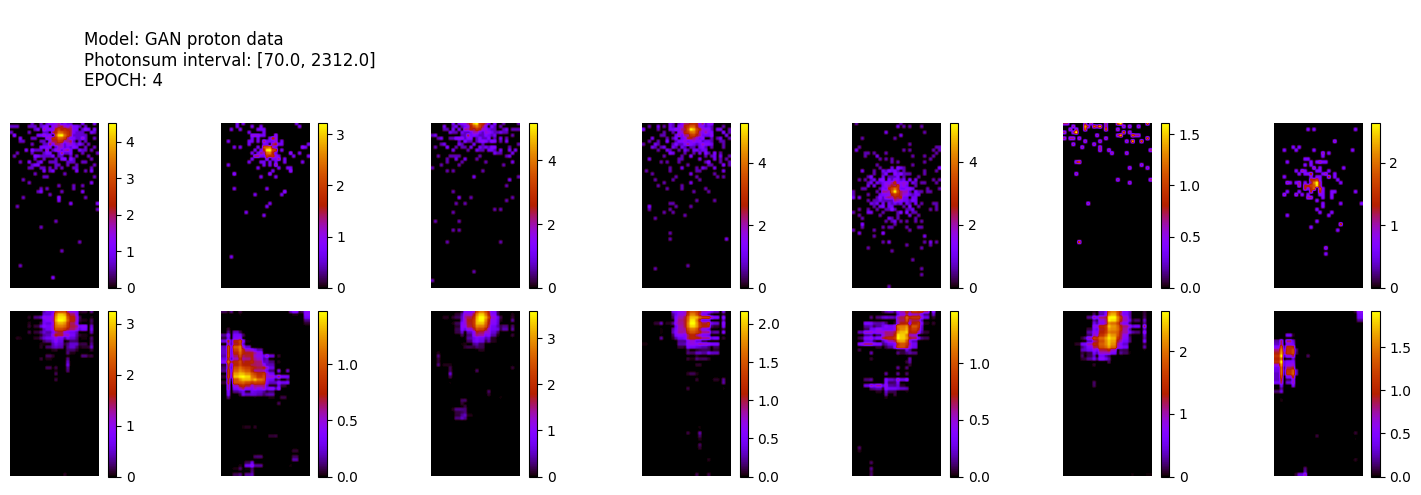

256/256 [==============================] - 1s 4ms/step
ws mean 58.24 ch1 0.13 ch2 46.70 ch3 0.47 ch4 98.76 ch5 145.15 Time for epoch 5 is 23.817436695098877 sec
1300 [D real acc: 63.41%] [D fake acc: 69.83%] [G acc: 30.17%] 
1400 [D real acc: 64.35%] [D fake acc: 69.92%] [G acc: 30.08%] 
1500 [D real acc: 65.01%] [D fake acc: 70.05%] [G acc: 29.95%] 


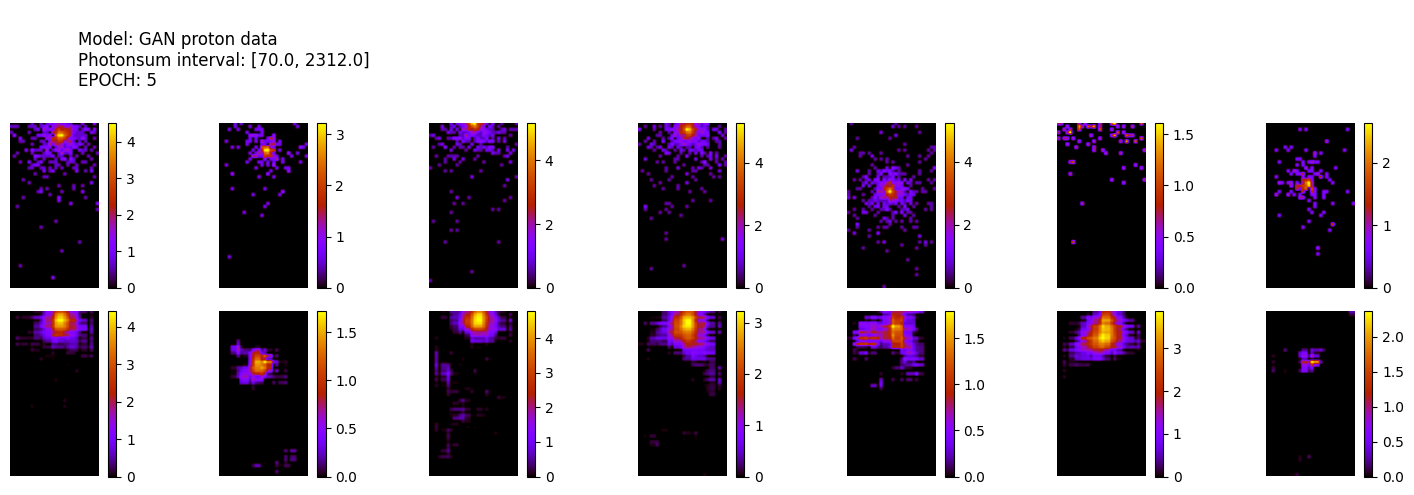

256/256 [==============================] - 1s 4ms/step
ws mean 65.76 ch1 0.17 ch2 52.31 ch3 0.76 ch4 118.09 ch5 157.45 Time for epoch 6 is 25.707582235336304 sec
1600 [D real acc: 65.69%] [D fake acc: 70.19%] [G acc: 29.81%] 
1700 [D real acc: 66.40%] [D fake acc: 70.41%] [G acc: 29.59%] 


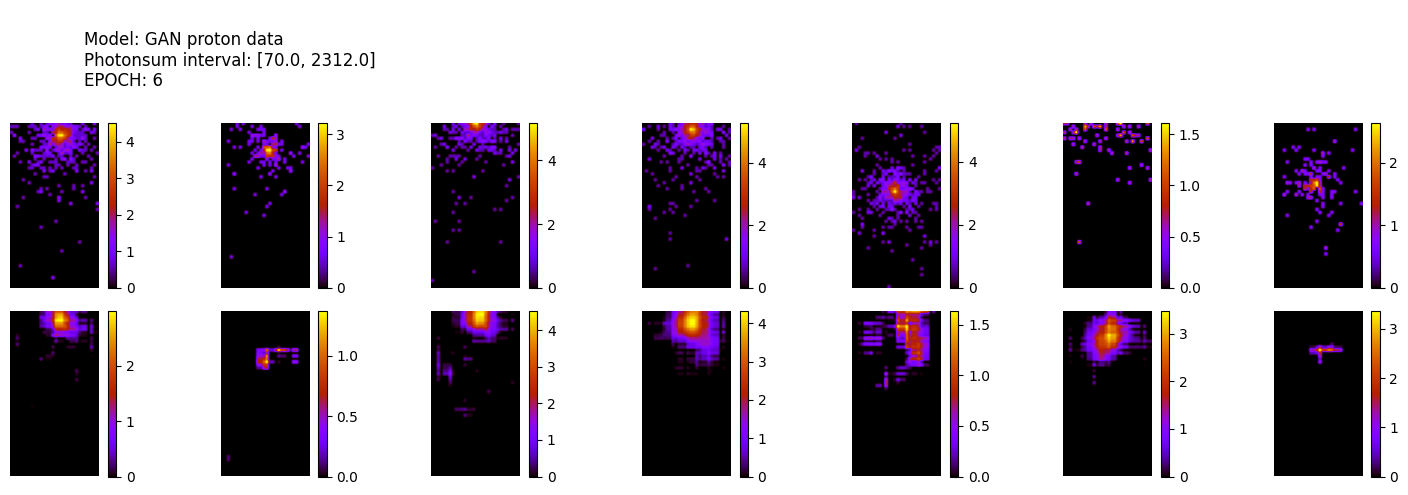

256/256 [==============================] - 1s 4ms/step
ws mean 66.56 ch1 0.06 ch2 61.71 ch3 0.61 ch4 116.16 ch5 154.25 Time for epoch 7 is 25.944427490234375 sec
1800 [D real acc: 67.04%] [D fake acc: 70.69%] [G acc: 29.31%] 
1900 [D real acc: 67.72%] [D fake acc: 71.02%] [G acc: 28.98%] 


In [ ]:
print("Images are saved in: ", filepath_img)
print("Models are saved in: ", filepath_mod)
history=train(dataset_with_cond, EPOCHS)